In [1]:
import csv
import random
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
vocab_size = 10000
embedding_dim = 64
max_length = 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
train_split = 0.7

In [3]:
url = "https://raw.githubusercontent.com/DuitDojo-Capstone-Project/DuitDojo_ML/main/text%20classification/data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame to verify the data
df.head()

,Items,Category
0,movie streaming subscription,utility
1,top up dana,utility
2,top up google play,utility
3,top up dana,utility
4,top up google play,utility


In [4]:
items_list = df['Items'].tolist()
category_list = df['Category'].str.strip().tolist()
data_list = list(zip(items_list, category_list))
random.shuffle(data_list)
items_list, category_list = zip(*data_list)

In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(category_list)
one_hot_labels = to_categorical(encoded_labels)

In [6]:
# Split the data into training (70%), validation (15%), and test (15%) sets
train_items, temp_items = train_test_split(items_list, test_size=0.3, random_state=42)
val_items, test_items = train_test_split(temp_items, test_size=0.5, random_state=42)
train_labels, temp_labels = train_test_split(one_hot_labels, test_size=0.3, random_state=42)
val_labels, test_labels = train_test_split(temp_labels, test_size=0.5, random_state=42)

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_items)
train_sequences = tokenizer.texts_to_sequences(train_items)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_sequences = tokenizer.texts_to_sequences(val_items)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_items)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [8]:
print(len(train_padded))
print(len(train_labels))
print(len(val_padded))
print(len(val_labels))
print(len(test_padded))
print(len(test_labels))

1376
1376
295
295
296
296


In [9]:
print(val_labels[0:10])

[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [10]:
from keras.callbacks import LearningRateScheduler
import math

def learning_rate_schedule(epoch):
    initial_learning_rate = 0.001
    drop = 0.5
    epochs_drop = 10
    learning_rate = initial_learning_rate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return learning_rate

lr_schedule = LearningRateScheduler(learning_rate_schedule)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_labels,
                    epochs=100,
                    validation_data=(val_padded, val_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 10, 16)            0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 160085 (625.33 KB)
Trainable params: 160085 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [12]:
model_dropout = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')])

model_dropout.summary()
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_dropout = model_dropout.fit(train_padded, train_labels,
                    epochs=100,
                    validation_data=(val_padded, val_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 16)            160000    
                                                                 
 dropout_2 (Dropout)         (None, 10, 16)            0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 160085 (625.33 KB)
Trainable params: 160085 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [23]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm.summary()
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(train_padded, train_labels,
                    epochs=100,
                    validation_data=(val_padded, val_labels),
                    batch_size=32,
                    callbacks=[lr_schedule])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 10, 64)            640000    
                                                                 
 dropout_20 (Dropout)        (None, 10, 64)            0         
                                                                 
 bidirectional_10 (Bidirect  (None, 64)                24832     
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 5)                 325       
                                                                 
Total params: 665157 (2.54 MB)
Trainable params: 665157 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [14]:
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    tf.keras.layers.Conv1D(48, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_conv.summary()
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_conv = model_conv.fit(train_padded, train_labels,
                    epochs=50,
                    validation_data=(val_padded, val_labels),
                    batch_size=32,
                    callbacks=[lr_schedule])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 6, 48)             30768     
                                                                 
 global_average_pooling1d_2  (None, 48)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                      

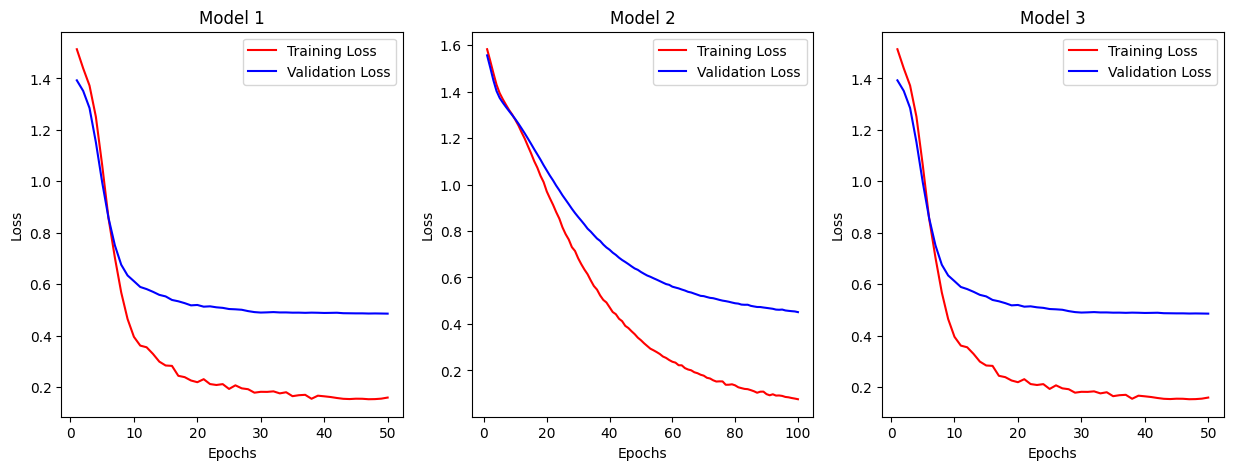

In [32]:
models = [history, history_dropout, history_conv]

# Set up subplots
fig, axs = plt.subplots(1, len(models), figsize=(15, 5))

for i, history in enumerate(models):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plot training loss
    axs[i].plot(epochs, loss, 'r', label='Training Loss')

    # Plot validation loss
    axs[i].plot(epochs, val_loss, 'b', label='Validation Loss')

    axs[i].set_title(f'Model {i+1}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.show()

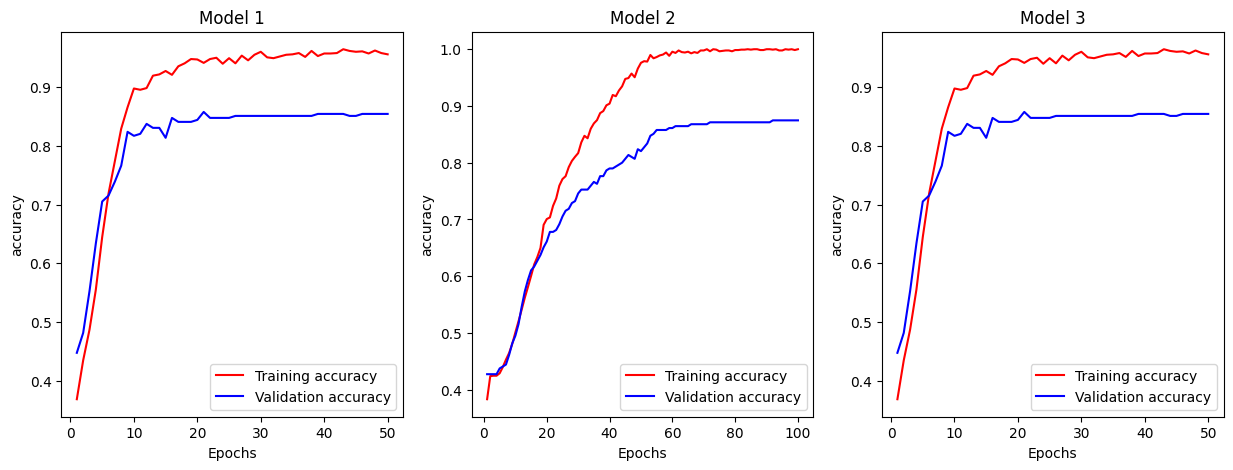

In [33]:
# Set up subplots
fig, axs = plt.subplots(1, len(models), figsize=(15, 5))

for i, history in enumerate(models):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)

    # Plot training accuracy
    axs[i].plot(epochs, accuracy, 'r', label='Training accuracy')

    # Plot validation accuracy
    axs[i].plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    axs[i].set_title(f'Model {i+1}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('accuracy')
    axs[i].legend()

plt.show()

In [34]:
model.evaluate(test_padded, test_labels)
model_dropout.evaluate(test_padded, test_labels)
model_lstm.evaluate(test_padded, test_labels)
model_conv.evaluate(test_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.6444 - accuracy: 0.7939


[0.6443860530853271, 0.7939189076423645]

In [35]:
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.01075


In [36]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [37]:
def encode(texts):
  text_sequences = tokenizer.texts_to_sequences(texts)
  text_padded = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return text_padded

In [39]:
texts = ['MUSTELA BABY OIL 100ML',
'NASI PUTIH',
'SATE PADANG',
'GULAI CUMI',
'DENDENG BALADO',
'KERUPUK KULIT',
'RENDANG DAGING',
'GULAI HATI',
'MUJAIR BAKAR',
'GULAI OTAK',
'AYAM BAKAR',
'SAMBAL TRI BELAH',
'LALAP SEGAR',
'AYAM PENYET',
'AYAM GORENG',
'AYAM POP',
'GULAI TUNJANG',
'TEH',
'VANDOOLEN',
'PLASTIK 25',
'Chicken HCC, 1Pcs',
'Colonel Burger',
'Ketoprak',
'AREM - AREM',
'LEMPER',
'PLASTIK KECIL',
'OMA NASI KUNING CAKALANG MANI',
'Cuka Apel Moringa',
'GONG GIBAB',
'BO SSAM',
'HAEMUL DENJANG JJIGAE',
'MULNAENGMYO N',
'MINI CHOCO',
'DumDum Thai Iced Green Tea',
'H COUPLE SEA',
'BURGER CHIC DECKER',
'Home Made Lemonade',
'KOREAN CURRY M',
'ALMOND CHOCO CREAMCHEESE',
'Nutella Cheese',
'Toblerone BanCheese',
'CHOCO PUFF',
'CREAMY BEEF CLS FTC',
'NEW ORIENTAL CHK RICE',
'LIPTON PITCHER',
'SC/P SUPER SUPREME',
'CB/P BLACK PEPP BEEF',
'Large *Plastik Kcl',
'BASO TAHU BIHUN',
'ICED TT',
'Jamur Crispy',
'Nasi Putih',
'Sambel Kecap',
'Es Teh',
'Sweet Plum Potato',
'CHO MOUSSE',
'GRAPE JELLY',
'Kopi Susu Sudirman',
'Chocolate Twist',
'RTD Kunyit',
'Tepung Jagung',
'SHOPPING BAG ROTI"O" 370/M',
'KFC Winger HC',
'Rice',
'THAI ICED TEA (L)',
'BASO TAHU',
'NASI PUTIH',
'PL. MUFFIN BLUEBERRY',
'RB. ABON AYAM',
'RB. COKLAT COFFEE',
'RB. RED BEAN',
'ROTI KEJU COKLAT',
'ROTI MAHKOTA/RING',
'ROTI KACANG MERAH',
'ROTI COKLAT',
'CHICKEN KATSU',
'TORI NASU HASAMI AGE',
'Mineral Water (S)',
'Pocky Chocolate',
'Nerds Strw Grape',
'Nerds Trop Punch',
'Nerds Watermelon',
'TRIPPLE CHEESE',
'RALPH BREAKS THE INTERNET : WR',
'PIS COK KEJU',
'COKLAT KEJU',
'BANANA KISMIS',
'BOTOL(MOMOGI BOTOL KACA ASI)',
'SPECTRA BREAST DISPOSABLE PADS (IRIS) / BP-0001 (BREASTPADS)',
'PAKET BULGOGI 3',
'BANANA MLK+MATCHA PU',
'KRN FRIED CHICKN HNY',
'TAKOYAKI 12PCS',
'NUMER CANDLE NO.1',
'NUMER CANDLE NO.2',
'6001-Plastic Bag Small',
'HOT TEA',
'AQUA',
'ICED TEA',
'ICED TEA',
'KOPI SUSU',
'Toblerone BanCheese']
padded_inputs = encode(texts)
padded_inputs_tensor = tf.convert_to_tensor(np.array(padded_inputs))
predictions = model_dropout.predict(padded_inputs_tensor)

for i, text in enumerate(texts):
    predicted_class = np.argmax(predictions[i])
    predicted_label = label_encoder.classes_[predicted_class]
    print(f"Input Text: {text}, Predicted Label: {predicted_label}")

4/4 [==============================] - 0s 6ms/step
Input Text: MUSTELA BABY OIL 100ML, Predicted Label: others
Input Text: NASI PUTIH, Predicted Label: food
Input Text: SATE PADANG, Predicted Label: food
Input Text: GULAI CUMI, Predicted Label: food
Input Text: DENDENG BALADO, Predicted Label: food
Input Text: KERUPUK KULIT, Predicted Label: food
Input Text: RENDANG DAGING, Predicted Label: food
Input Text: GULAI HATI, Predicted Label: food
Input Text: MUJAIR BAKAR, Predicted Label: food
Input Text: GULAI OTAK, Predicted Label: food
Input Text: AYAM BAKAR, Predicted Label: food
Input Text: SAMBAL TRI BELAH, Predicted Label: food
Input Text: LALAP SEGAR, Predicted Label: others
Input Text: AYAM PENYET, Predicted Label: food
Input Text: AYAM GORENG, Predicted Label: food
Input Text: AYAM POP, Predicted Label: food
Input Text: GULAI TUNJANG, Predicted Label: food
Input Text: TEH, Predicted Label: food
Input Text: VANDOOLEN, Predicted Label: food
Input Text: PLASTIK 25, Predicted Label: ot

In [40]:
model.save('model.h5')
model_dropout.save('model_dropout.h5')
model_lstm.save('model_lstm.h5')
model_conv.save('model_conv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
